# Filtering
## Motivation
Suppose that we have two photos taken at similar time interval of the same static object.
Notice that the digital image formed will not be exactly the same, due to noise in the sensors and minor differences in lighting conditions.
Thus, we would wish to remove noise from our images.

## Types of noise
There are many types of noise, including

1. Salt and Pepper noise
    * Random occurrences of black and white pixels
    * Usually due to defects in the sensors.

2. Gaussian noise
    * Variation in intensity of each pixel drawn from a Gaussian distribution
    * Due to inherent noise of sensors and minute changes in lighting conditions.

In [129]:
def show_images(img_label_tuples, grey=True, autoscale=False):
    n = len(img_label_tuples)
    f = plt.figure(figsize=(20,10))
    
    axes = [f.add_subplot(100 + 10 * n + i) for i in range(1, n+1)]
    
    vmax = 1 if all([image.max() <= 1 for image, _ in img_label_tuples]) else 255
    

    for ax, (image, label) in zip(axes, img_label_tuples):
        ax.title.set_text(label)
        if autoscale:
            vmax = image.max()
        if grey:
            ax.imshow(image, cmap='gray', vmin=0, vmax=vmax)
        else:
            ax.imshow(image)
            
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

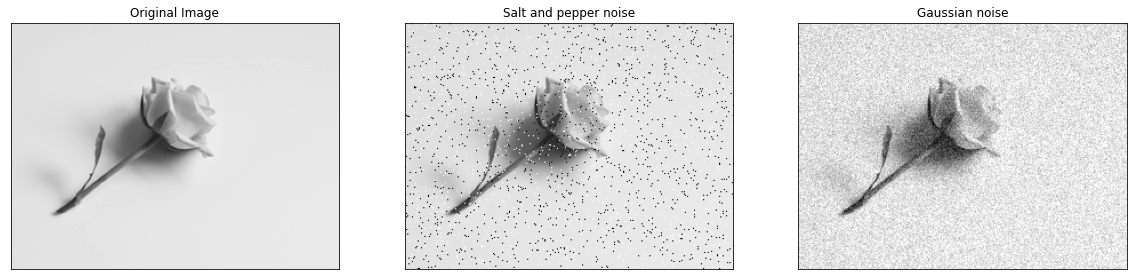

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


image = Image.open('images/rose.jpg').resize((288, 216)).convert('L')
image = np.array(image)


def salt_and_pepper(img):
    img = np.array(img).astype(np.int16)
    
    mask = np.random.choice([-1, 0, 1], size=img.shape, p=[0.02, 0.96, 0.02]).astype(np.int8)
    img = img + 255 * mask
    
    return np.clip(img, 0, 255)

def gaussian_noise(img, mu=0, sigma=20):
    img = np.array(img).astype(np.int16)
    mask = np.random.normal(mu, sigma, img.shape)
    img = img + mask
    
    return np.clip(img, 0, 255)
    
    
show_images([(image, 'Original Image'),
            (salt_and_pepper(image), 'Salt and pepper noise'),
            (gaussian_noise(image), 'Gaussian noise')
            ])

Suppose we plot the intensity plot around a noisy region.
We can make the assumption that noise correlate to the pixels whose intensity values are vastly different from its neighbours, like in the case of salt and pepper noise.
Thus, we can "smoothen" the image out by focusing on the average intensity values of the region in the image instead.

We can generalize and formalize this, where given image with pixel values of $p_{i, j}$, a window of size $2k+1 \times 2k+1$ where the center pixel is $f_{0,0}$, the resultant image $x$ is 

$$
x_{i,j} = \sum ^k _{u = -k} \sum ^k _{v = -k} f_{u, v} p_{i + u, j+v}
$$

(This operation is called **correlation filtering**)

Thus, suppose we wish to average the pixels in a $3\times 3$ area, then it simply corresponds to using a filter which is a $3\times 3$ grid of $\frac{1}{9}$.
The "averaging" filter is also known as a **box filter**.

Notice that because each pixel in the new image corresponds to a region in the original, the new image is smaller than the original image.
We can either accept this as it is, or we could pad the original image on all sides before filtering, to maintain the size of the resultant image; at the cost of some artifacts at the borders of the new image.

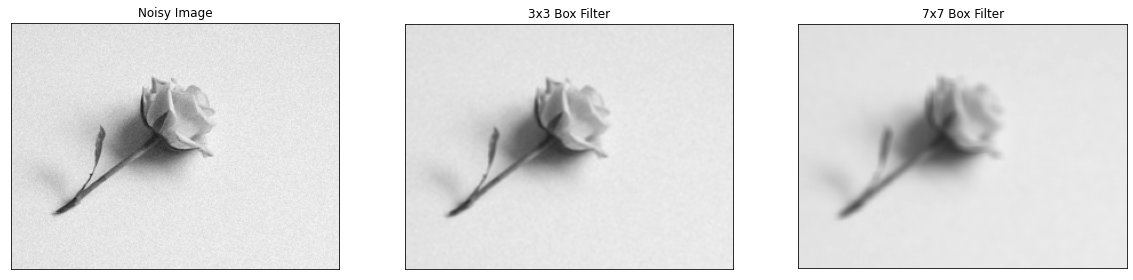

In [131]:
noisy_image = gaussian_noise(image, sigma=5)

def correlation_filter(img, window=np.ones((3, 3))/9):
    height, width = img.shape
    
    assert window.shape[0] == window.shape[1]
    
    window_size = window.shape[0]
    
    new_image = np.zeros((height-window_size, width-window_size))
    
    for i in range(0, height - window_size):
        for j in range(0, width - window_size):
            new_image[i][j] = (window * img[i:i+window_size, j:j+window_size]).sum()
    return np.clip(new_image, 0, 255)

show_images([(noisy_image, 'Noisy Image'),
            (correlation_filter(noisy_image), '3x3 Box Filter'),
            (correlation_filter(noisy_image, window=np.ones((7, 7))/49), '7x7 Box Filter')
            ])

Notice that after filtering, the noise becomes less pronounced.
However, using a large window will blur the image.

We can use a higher weight for the pixels that are closer to the center of the window, so that the resultant pixel intensity will be closer to that of the original pixel.
One easy filter to use is the Gaussian filter, where the center pixel has the value of 1, and the other pixel have smaller value the further it is from the center, as in a Gaussian function.
$\sigma$ controls how large the Gaussian kernel is, thus controlling the amount of smoothing.


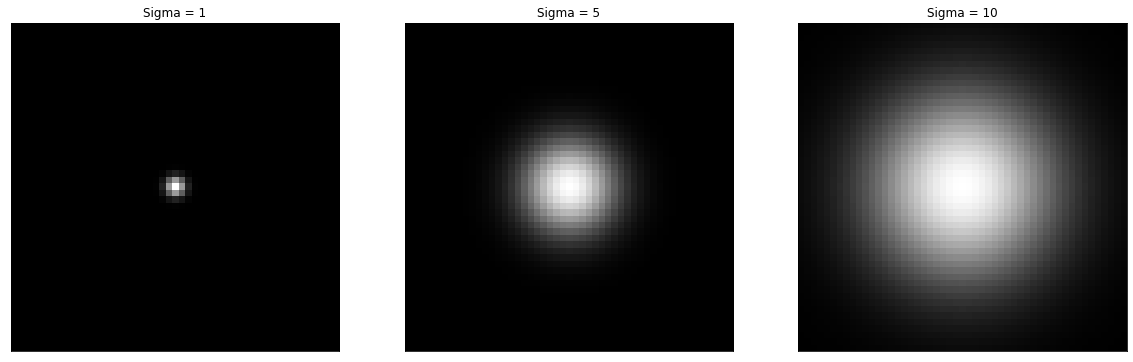

In [132]:
noisy_image = gaussian_noise(image, sigma=5)

def gaussian_filter(size, sigma=1):
    assert size % 2 == 1
    
    kernel = np.ones((size, size), np.float64)
    k = size // 2
    for i in range(size):
        for j in range(size):
            exponent = -((i - k)**2 + (j-k)**2) / (2 * sigma**2) 
            kernel[i][j] = np.exp(exponent)/ (2 * np.pi*sigma**2)
    return kernel

show_images([(gaussian_filter(51, 1), "Sigma = 1"),
            (gaussian_filter(51, 5), "Sigma = 5"),
            (gaussian_filter(51, 10), "Sigma = 10")], autoscale=True)

(Note that we scaled intensity values of the kernels with the larger sigmas, otherwise it will not be visible)

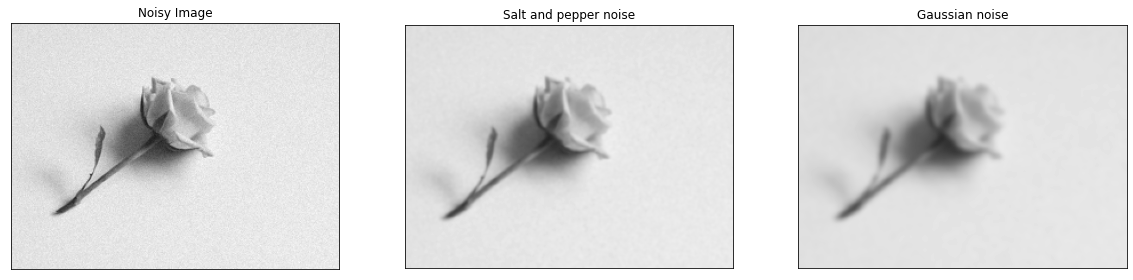

In [134]:
show_images([(noisy_image, 'Noisy Image'),
            (correlation_filter(noisy_image, window=gaussian_filter(11, 1)), 'Salt and pepper noise'),
            (correlation_filter(noisy_image, window=gaussian_filter(11, 2)), 'Gaussian noise')
            ])

Note that the Gaussian filter perform better than the box filter as it removes the noise better while not blurring as much.